## Imports

In [110]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torchvision import models, transforms, datasets
from tqdm import tqdm

torch.cuda.is_available()

True

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import shutil

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Visualize the data

In [113]:
def plot_accuracy_from_history(*histories, labels=None) -> None:
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history['accuracy']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

# Transfer Learning

## Prepare Data

In [114]:
EPOCHS: int = 5

In [115]:

kaggle_dir = "flowers"
    
processed_dir = kaggle_dir + "/processed"
flowers_dir = processed_dir + ""
base_dir = flowers_dir + "/"

train_dir: str = base_dir + "train/"
train_daisy_dir: str = train_dir + "daisy/"
train_dandelion_dir: str = train_dir + "dandelion/"
train_rose_dir: str = train_dir + "rose/"
train_sunflower_dir: str = train_dir + "sunflower/"
train_tulip_dir: str = train_dir + "tulip/"

validation_dir: str = base_dir + "validation/"
validation_daisy_dir: str = validation_dir + "daisy/"
validation_dandelion_dir: str = validation_dir + "dandelion/"
validation_rose_dir: str = validation_dir + "rose/"
validation_sunflower_dir: str = validation_dir + "sunflower/"
validation_tulip_dir: str = validation_dir + "tulip/"

test_dir: str = base_dir + "test/"
test_daisy_dir: str = test_dir + "daisy/"
test_dandelion_dir: str = test_dir + "dandelion/"
test_rose_dir: str = test_dir + "rose/"
test_sunflower_dir: str = test_dir + "sunflower/"
test_tulip_dir: str = test_dir + "tulip/"

models_dir: str = "models/"

def create_dirs() -> None:
    all_paths: list[str] = [kaggle_dir, processed_dir, flowers_dir,
                            base_dir, train_dir, train_daisy_dir, train_dandelion_dir, train_rose_dir, train_sunflower_dir, train_tulip_dir, validation_dir, validation_daisy_dir, validation_dandelion_dir, validation_rose_dir, validation_sunflower_dir, validation_tulip_dir, test_dir, test_daisy_dir, test_dandelion_dir, test_rose_dir, test_sunflower_dir, test_tulip_dir, models_dir]
    # create dirs if not exist
    for path in all_paths:
        if not os.path.exists(path):
            os.makedirs(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train') -> None:
    for index in indices:
        src: str = f"{kaggle_dir}/original/train/{animal}.{index}.jpg"
        dst: str = f"{kaggle_dir}/processed/flowers/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size_ratio = 0.1, test_size_ratio = 0.1) -> None:
    remove_images()

    create_dirs()
    print("Dirs created")
    
    directories: list[str] = os.listdir("kaggle/flowers/original/train")
    
    print("Dirs listed")

    for directory in directories:
        if not os.path.exists(f"{base_dir}train/{directory}"):
            os.makedirs(f"{base_dir}train/{directory}")
        if not os.path.exists(f"{base_dir}validation/{directory}"):
            os.makedirs(f"{base_dir}validation/{directory}")
        if not os.path.exists(f"{base_dir}test/{directory}"):
            os.makedirs(f"{base_dir}test/{directory}")
            
    print("Dirs created")
            
    for directory in directories:
        files = glob.glob(f"kaggle/flowers/original/train/{directory}/*.jpg")
        
        total_size = len(files)
        
        validation_size = int(total_size * validation_size_ratio)
        test_size = int(total_size * test_size_ratio)
        train_size = total_size - validation_size - test_size
        
        np.random.shuffle(files)
        
        train_files = files[:train_size]
        validation_files = files[train_size:train_size + validation_size]
        test_files = files[train_size + validation_size:]
        
        for file in train_files:
            shutil.copy(file, f"{base_dir}train/{directory}/")
        for file in validation_files:
            shutil.copy(file, f"{base_dir}validation/{directory}/")
        for file in test_files:
            shutil.copy(file, f"{base_dir}test/{directory}/")
    
    print("Images copied")

In [116]:
copy_all_images()

Dirs created
Dirs listed
Dirs created
Images copied


In [117]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=False) for x in ['train', 'validation', 'test']}


In [118]:
COUNT_OF_CLASSES = len(image_datasets['train'].classes)
print(COUNT_OF_CLASSES)

5


## Features Extraction Method (caching ResNet so faster but no augmentation)

### Define ResNet Model

In [119]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        return x

### Extract features from ResNet

In [120]:
def extract_features(model, dataloader, dataset_size) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    features = torch.zeros(dataset_size, 512, 4, 4, device=device)
    labels = torch.zeros(dataset_size, device=device)
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            # Reshape or unsqueeze outputs to match the shape of features
            outputs = torch.unsqueeze(torch.unsqueeze(outputs, -1), -1)
            features[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = outputs
            labels[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = labels_batch
    return features, labels

In [121]:
resnet_model = ResNetModel().to(device)

train_features, train_labels = extract_features(resnet_model, dataloaders['train'], len(image_datasets['train']))
validation_features, validation_labels = extract_features(resnet_model, dataloaders['validation'], len(image_datasets['validation']))
test_features, test_labels = extract_features(resnet_model, dataloaders['test'], len(image_datasets['test']))

# Reshape
train_features = train_features.view(len(image_datasets['train']), -1)
validation_features = validation_features.view(len(image_datasets['validation']), -1)
test_features = test_features.view(len(image_datasets['test']), -1)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1831, 8192])
torch.Size([226, 8192])
torch.Size([226, 8192])


In [122]:
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
validation_dataset = torch.utils.data.TensorDataset(validation_features, validation_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

### New model

In [135]:
class ModelWithExtracted(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(train_features.shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES)
        )

    def forward(self, x):
        x = self.model(x)
        return x

### Train

In [148]:
model1 = ModelWithExtracted().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

def train_model(model, criterion, optimizer) -> None:
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects / len(image_datasets['train'])
        accuracy_history.append(epoch_acc)
        loss_history.append(epoch_loss)
        
        inputs_val, labels_val = next(iter(validation_loader))
        with torch.no_grad():
            model.eval()
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.long().to(device)
            val_outputs = model(inputs_val)
            val_loss = criterion(val_outputs, labels_val)
            val_preds = torch.round(val_outputs)
            val_acc = torch.sum(torch.argmax(val_preds, 1) == labels_val).item() / len(labels_val)
            val_accuracy_history.append(val_acc)
            val_loss_history.append(val_loss)
        
            print(f"Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    history = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }
    return history
        
history1 = train_model(model1, criterion, optimizer)

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:01<00:00, 52.80it/s]


Epoch 1/5 Loss: 0.7850 Acc: 0.7313
Validation Loss: 0.9704 Acc: 0.8000


100%|██████████| 92/92 [00:20<00:00,  4.46it/s]


Epoch 2/5 Loss: 0.3762 Acc: 0.8695
Validation Loss: 0.1665 Acc: 0.9500


100%|██████████| 92/92 [00:22<00:00,  4.03it/s]


Epoch 3/5 Loss: 0.2896 Acc: 0.8919
Validation Loss: 0.5734 Acc: 0.8500


100%|██████████| 92/92 [00:12<00:00,  7.13it/s]


Epoch 4/5 Loss: 0.2340 Acc: 0.9197
Validation Loss: 0.6688 Acc: 0.8000


100%|██████████| 92/92 [00:13<00:00,  6.68it/s]

Epoch 5/5 Loss: 0.2166 Acc: 0.9219
Validation Loss: 0.0505 Acc: 1.0000


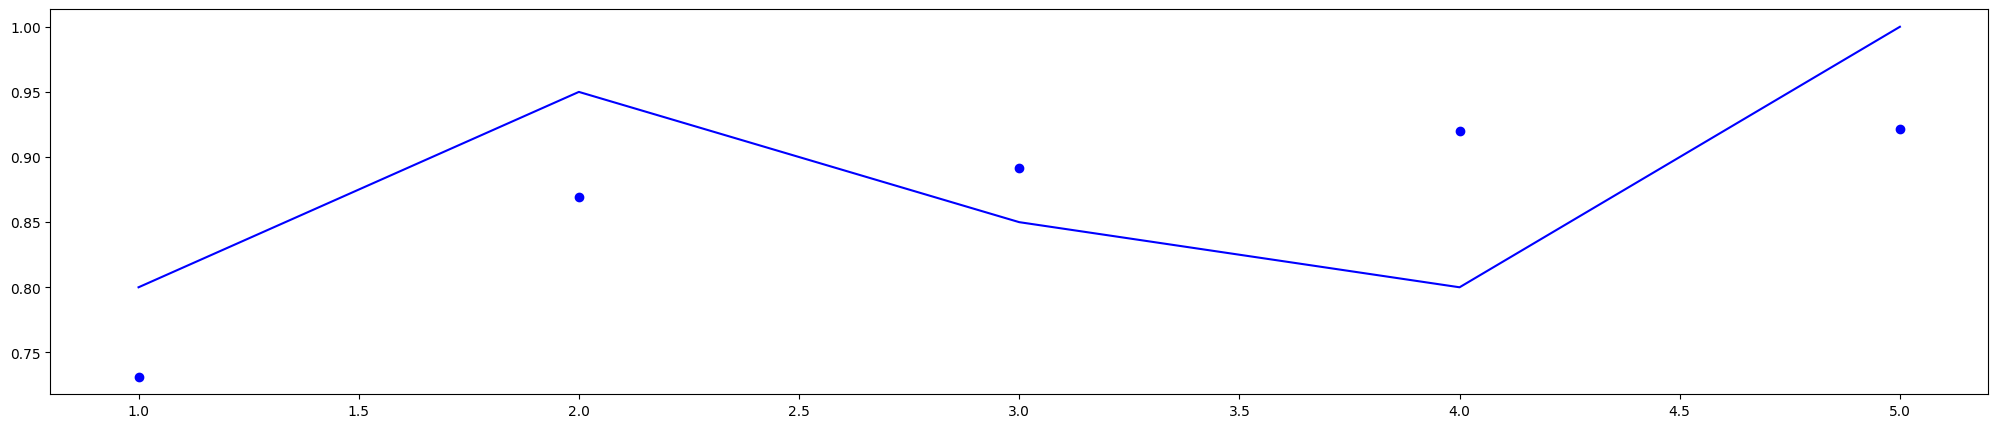

In [149]:
history1 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history1.items()}
plot_accuracy_from_history(history1)

## Fine-Tuning method (slower but with augmentation)

### Prepare Data

In [150]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # random horizontal flip
        transforms.RandomHorizontalFlip(),
        # random Linear Transformation
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=False) for x in ['train', 'validation', 'test']}


### Create model

In [151]:
class ModelFineTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model2 = ModelFineTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model2.parameters(), lr=2e-5)

/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [152]:
# Training loop
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    
    model2.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model2.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model2(inputs)
            val_loss = criterion(outputs, labels.float())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history2: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
}
    
    

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Epoch 1/5 Loss: 96.4222 Acc: 0.2780
Validation Loss: 91.5407 Acc: 0.2168


100%|██████████| 92/92 [00:09<00:00,  9.68it/s]


Epoch 2/5 Loss: 96.4168 Acc: 0.2403
Validation Loss: 91.5399 Acc: 0.2212


100%|██████████| 92/92 [00:08<00:00, 10.79it/s]


Epoch 3/5 Loss: 96.4157 Acc: 0.2201
Validation Loss: 91.5403 Acc: 0.2212


100%|██████████| 92/92 [00:08<00:00, 10.30it/s]


Epoch 4/5 Loss: 96.4148 Acc: 0.2245
Validation Loss: 91.5383 Acc: 0.2212


100%|██████████| 92/92 [00:08<00:00, 10.38it/s]


Epoch 5/5 Loss: 96.4148 Acc: 0.2316
Validation Loss: 91.5393 Acc: 0.2212


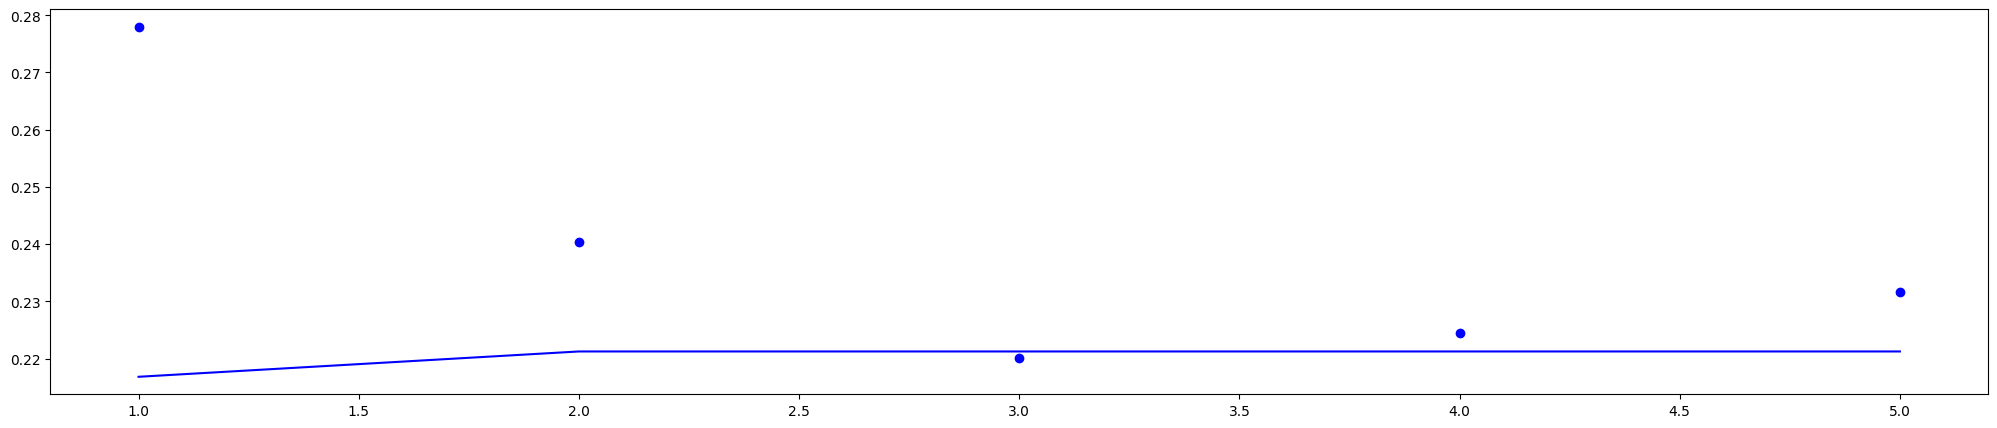

In [153]:
history2 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history2.items()}
plot_accuracy_from_history(history2)

# Tuning Method (unfreeze few layers from ResNet)

In [154]:
class ModelTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        for param in self.resnet.layer4.parameters(): # unfreeze the last layer
            param.requires_grad = True
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            nn.Flatten(0, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model3 = ModelTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model3.parameters(), lr=2e-5)

In [155]:
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    model3.train()
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train'], disable=True):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model3(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model3.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model3(inputs)
            val_loss = criterion(outputs, labels.float())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history3: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }

Epoch 1/5 Loss: 96.4140 Acc: 0.2223
Validation Loss: 91.5364 Acc: 0.2212
Epoch 2/5 Loss: 96.4114 Acc: 0.2185
Validation Loss: 91.5380 Acc: 0.2212
Epoch 3/5 Loss: 96.4094 Acc: 0.2196
Validation Loss: 91.5349 Acc: 0.2212
Epoch 4/5 Loss: 96.4077 Acc: 0.2190
Validation Loss: 91.5379 Acc: 0.2212
Epoch 5/5 Loss: 96.4066 Acc: 0.2163
Validation Loss: 91.5391 Acc: 0.2212


[array(0.2222829, dtype=float32), array(0.21845984, dtype=float32), array(0.21955214, dtype=float32), array(0.219006, dtype=float32), array(0.21627524, dtype=float32)]


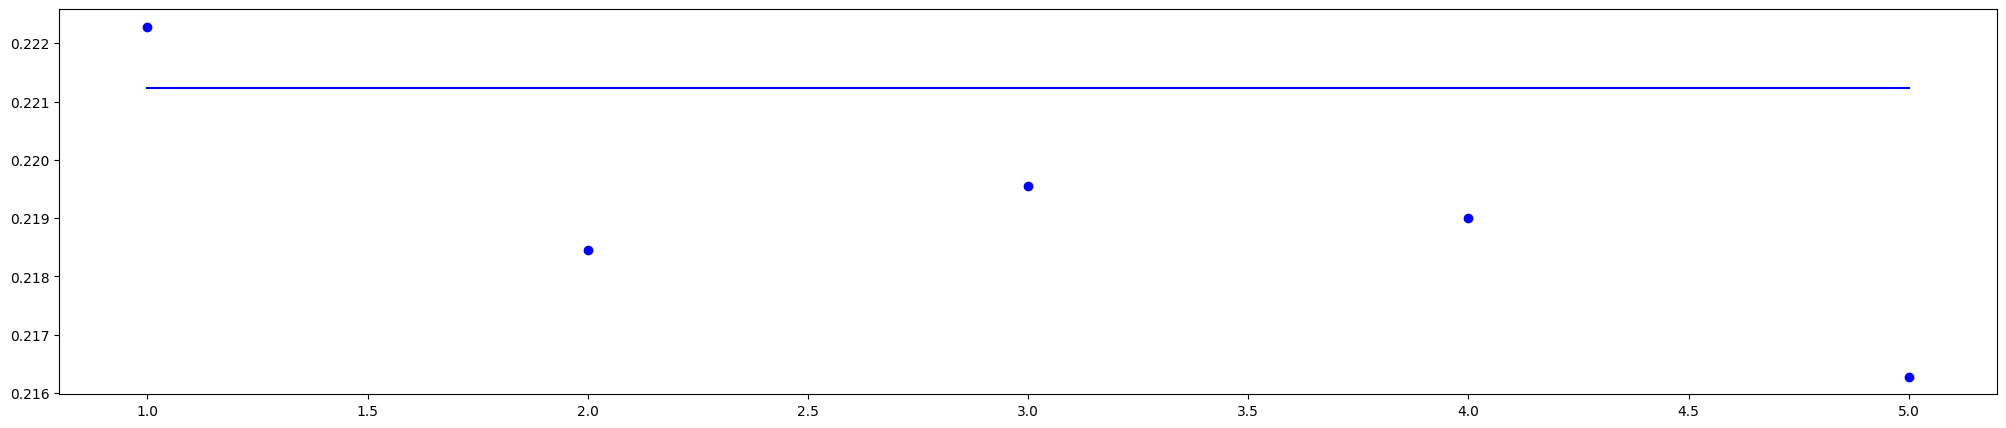

In [156]:
history3 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history3.items()}
plot_accuracy_from_history(history3)
print(history3['accuracy'])